In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import sys
import yaml
sys.path.append('.')
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
from ml_collections.config_dict import ConfigDict
from analysis_utils import envs

import jgnn_utils as jgnn_ut

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

2024-01-24 16:27:29.807088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 16:27:29.807137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 16:27:29.808667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 16:27:32.159239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Read in the generated dataset
dataset_name = 'wdm/balmy-sun-69'
dataset_path = envs.DEFAULT_OUTPUT_DIR / (dataset_name + '.npz')

dataset = np.load(dataset_path)
gen_samples = dataset['samples']
cond = dataset['cond']
mask = dataset['mask']
truth_samples = dataset['truth']

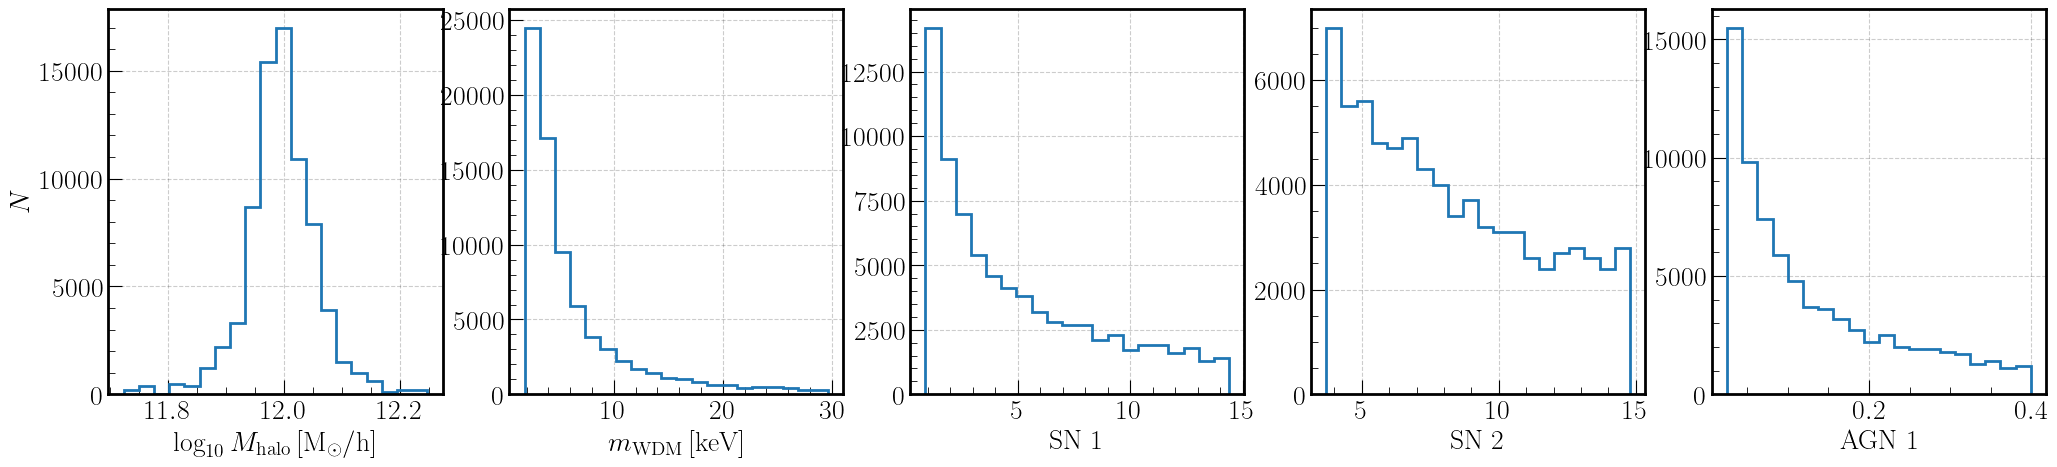

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    axes[i].hist(cond[:, i], bins=20, histtype='step', lw=2)

axes[0].set_xlabel(r'$\log_{10} M_\mathrm{halo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$m_\mathrm{WDM} \, [\rm keV]$')
axes[2].set_xlabel(r'SN 1')
axes[3].set_xlabel(r'SN 2')
axes[4].set_xlabel(r'AGN 1')
axes[0].set_ylabel(r'$N$')

plt.show()

In [84]:
bin_dim = 3
num_cond_bins = 4
sort_idx = np.argsort(cond[..., bin_dim])
bins_idx = np.array_split(sort_idx, num_cond_bins)

gen_samples_bins = []
truth_samples_bins = []
mask_bins = []
cond_bins = []

for i in range(num_cond_bins):
    cond_bins.append(cond[bins_idx[i]])
    gen_samples_bins.append(gen_samples[bins_idx[i]])
    truth_samples_bins.append(truth_samples[bins_idx[i]])
    mask_bins.append(mask[bins_idx[i]])

    print(f'Bin {i}: {len(bins_idx[i])}')
    print(f'- Min bin val: {np.min(cond[bins_idx[i]], axis=0)}')
    print(f'- Max bin val: {np.max(cond[bins_idx[i]], axis=0)}')

Bin 0: 18900
- Min bin val: [11.772782    1.8022758   0.9073496   3.7030413   0.02511596]
- Max bin val: [12.2051     29.68524    14.293637    5.4500422   0.39665923]
Bin 1: 18900
- Min bin val: [11.7385      1.8041806   0.90139735  5.468666    0.02523137]
- Max bin val: [12.162649   27.198975   14.353975    7.7231817   0.39381757]
Bin 2: 18900
- Min bin val: [11.77385     1.8711972   0.91705996  7.7338634   0.02519129]
- Max bin val: [12.235351   29.324564   14.396648   10.789915    0.39946827]
Bin 3: 18900
- Min bin val: [11.723461    1.8005176   0.91347545 10.797201    0.02500099]
- Max bin val: [12.246785   28.097128   14.263525   14.782352    0.39710528]


### Subhalo mass function

In [85]:
def get_histogram_q(samples, bins, q, cumulative=False):
    """ Compute the qth percentile of a samples of histograms. """
    counts = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    counts = np.stack(counts, axis=0)
    if cumulative:
        counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    return counts_q

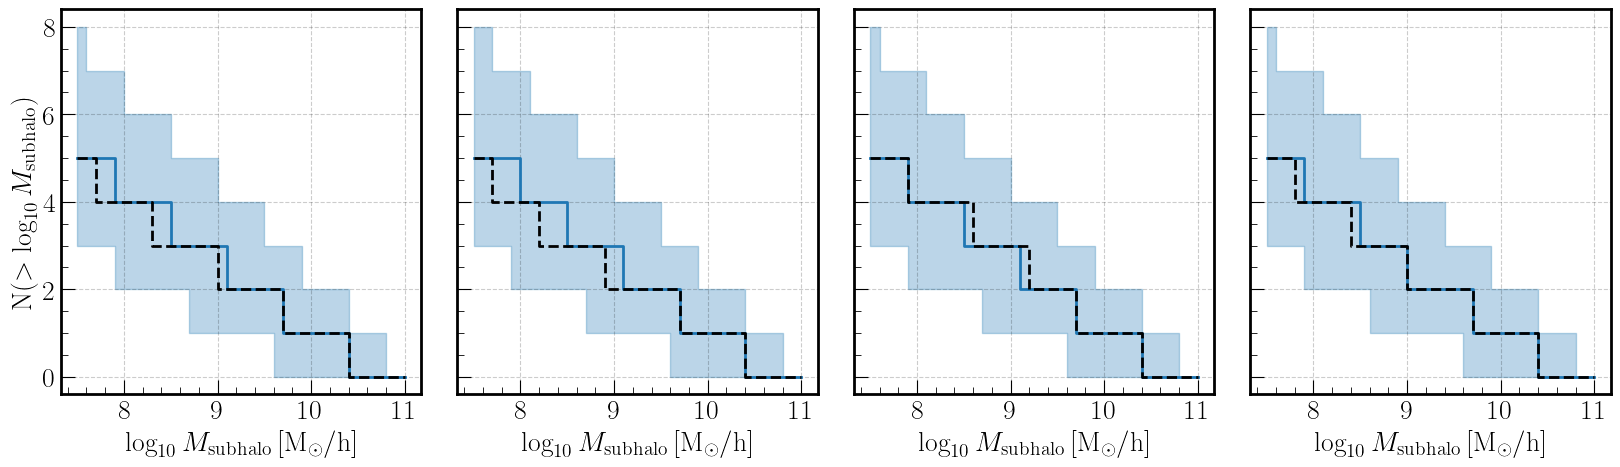

In [86]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.1
plot_range = (7.5, 11)
q = [50, 16, 84]
cumulative = True
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_cond_bins, figsize=(5 * num_cond_bins, 5), sharey=True, sharex=True)

for i in range(num_cond_bins):
    ax = axes[i]

    # plot the generated samples
    counts_q = get_histogram_q(
        gen_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth samples
    counts_q = get_histogram_q(
        truth_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')

axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

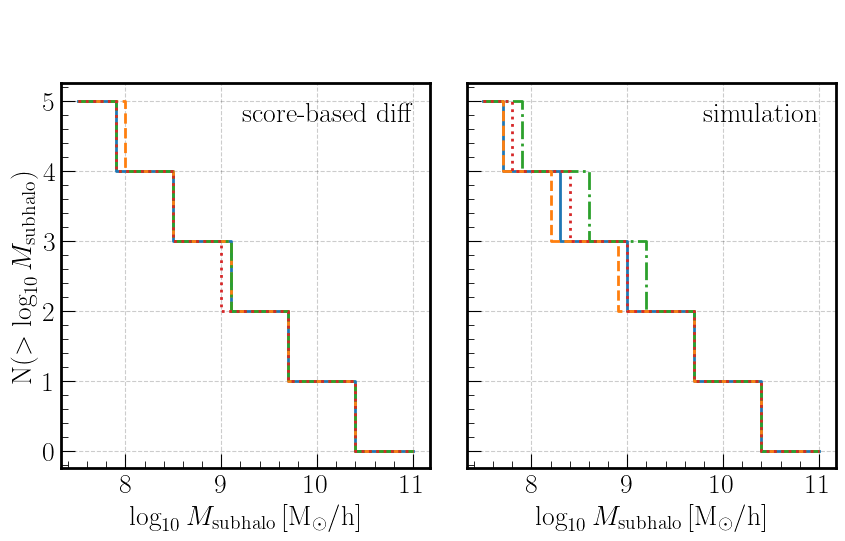

In [87]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.1
plot_range = (7.5, 11)
q = [50, 16, 84]
cumulative = True
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

colors = ['C0', 'C1', 'C2', 'C3']
linestyles = ['-', '--', '-.', ':']

fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the generated samples
for i in range(num_cond_bins):

    counts_q = get_histogram_q(gen_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    axes[0].plot(
        bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2,
        ls=linestyles[i])

    counts_q = get_histogram_q(truth_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    axes[1].plot(
        bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2,
        ls=linestyles[i])

axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
axes[0].set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, fontsize=16, loc='upper center', ncol=2,
    bbox_to_anchor=(0.5, 1.05))
axes[0].text(
    0.95, 0.95, 'score-based diff', transform=axes[0].transAxes,
    fontsize=20, va='top', ha='right')
axes[1].text(
    0.95, 0.95, 'simulation', transform=axes[1].transAxes,
    fontsize=20, va='top', ha='right')

fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Radius

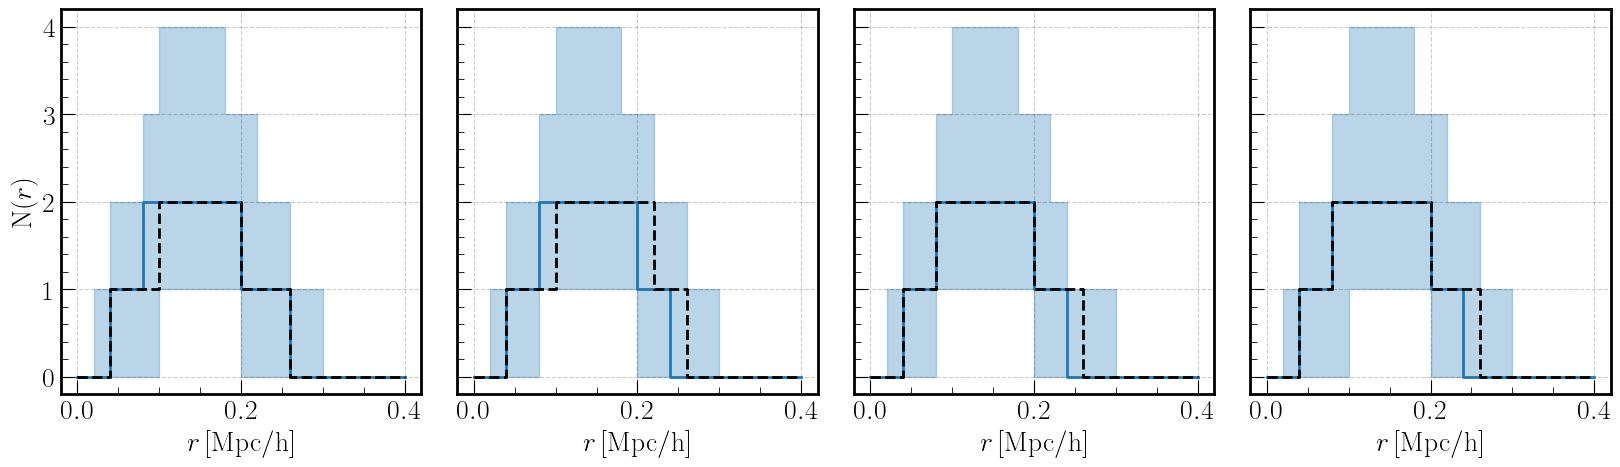

In [88]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.02
plot_range = (0., 0.4)
q = [50, 16, 84]
cumulative = False
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_cond_bins, figsize=(5 * num_cond_bins, 5), sharey=True, sharex=True)

for i in range(num_cond_bins):
    ax = axes[i]

    # plot the generated samples
    pos = gen_samples_bins[i][..., :3]
    rad = np.linalg.norm(pos, axis=-1)
    counts_q = get_histogram_q(rad, bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth samples
    pos = truth_samples_bins[i][..., :3]
    rad = np.linalg.norm(pos, axis=-1)
    counts_q = get_histogram_q(rad, bins, q=q, cumulative=cumulative)   
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')

# axes[0].set_yscale('log')
axes[0].set_ylabel(r'N($r$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$r \, [\rm Mpc / h]$')

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Density profiles

In [89]:
# calculate the density profiles for each WDM bins
r_min = 0.01
r_max = 0.5
num_bins = 5  # this is the number of bins for the density profile not the WDM mass
log_r_bins = np.linspace(np.log10(r_min), np.log10(r_max), num_bins + 1)

gen_log_rho = []
for i in range(num_cond_bins):
    temp = []
    for samples in gen_samples_bins[i]:
        pos = samples[..., :3]
        rad = np.linalg.norm(pos, axis=-1)
        log_mvir = samples[..., 6]

        rho = jgnn_ut.physics.particles.calc_rho(
            rad, 10**log_mvir, r_min, r_max, num_bins=num_bins)[0]
        temp.append(np.log10(rho))
    gen_log_rho.append(np.array(temp))

truth_log_rho = []
for i in range(num_cond_bins):
    temp = []
    for samples in truth_samples_bins[i]:
        pos = samples[..., :3]
        rad = np.linalg.norm(pos, axis=-1)
        log_mvir = samples[..., 6]

        rho = jgnn_ut.physics.particles.calc_rho(
            rad, 10**log_mvir, r_min, r_max, num_bins=num_bins)[0]
        temp.append(np.log10(rho))
    truth_log_rho.append(np.array(temp))

/tmp/ipykernel_3167122/2605486635.py:17: RuntimeWarning: divide by zero encountered in log10
  temp.append(np.log10(rho))
/tmp/ipykernel_3167122/2605486635.py:30: RuntimeWarning: divide by zero encountered in log10
  temp.append(np.log10(rho))


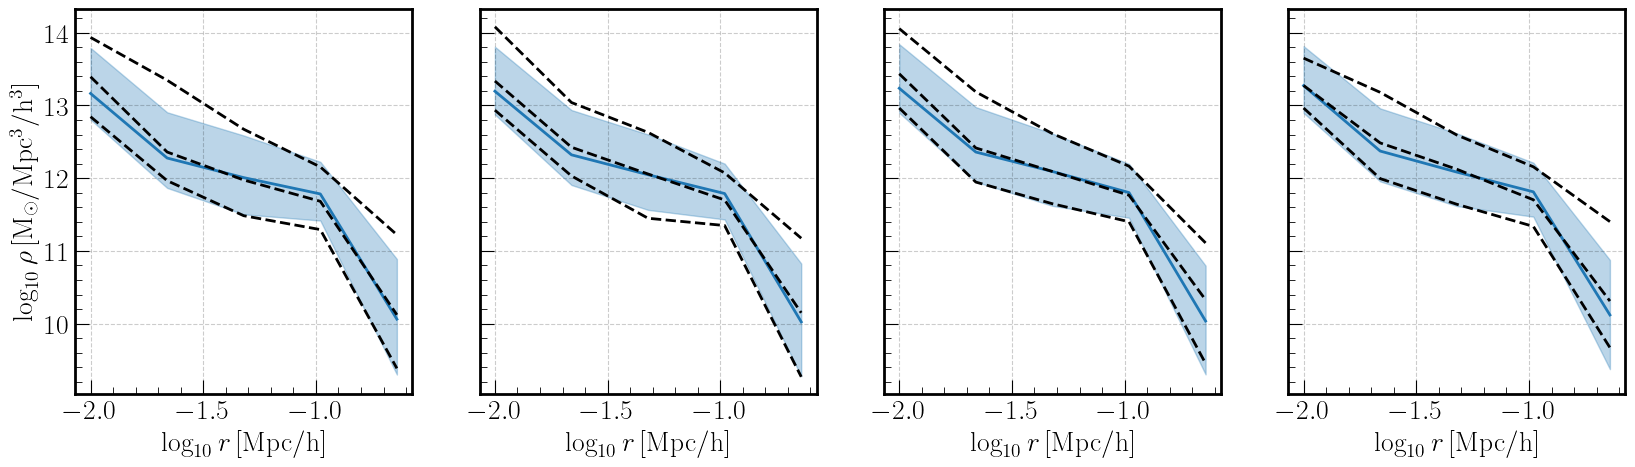

In [90]:
fig, axes = plt.subplots(
    1, num_cond_bins, figsize=(5 * num_cond_bins, 5), 
    sharey=True, sharex=True)

for i in range(num_cond_bins):
    ax = axes[i]
    
    y = gen_log_rho[i]
    y[np.isinf(y)] = np.nan
    gen_log_rho_q = np.nanpercentile(y, q=q, axis=0)
    ax.plot(
        log_r_bins[:-1], gen_log_rho_q[0], color='C0', lw=2,
        label='score-based diff')
    ax.fill_between(
        log_r_bins[:-1], gen_log_rho_q[1], gen_log_rho_q[2],
        color='C0', alpha=0.3)
    
    y = truth_log_rho[i]
    y[np.isinf(y)] = np.nan
    truth_log_rho_q = np.nanpercentile(y, q=q, axis=0)
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[0], color='k', lw=2,
        ls='--', label='simulation')
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[1], color='k', lw=2,
        ls='--')
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[2], color='k', lw=2,
        ls='--')
    ax.set_xlabel(r'$\log_{10} r \, [\rm Mpc / h]$')

axes[0].set_ylabel(r'$\log_{10} \rho \, [\rm M_\odot / \rm Mpc^3 / h^3]$')
plt.show()

### Vmax

/tmp/ipykernel_3167122/653855334.py:10: RuntimeWarning: invalid value encountered in log10
  ax.scatter(mass, np.log10(vmax_tilde), s=20, color='C0', alpha=0.5)


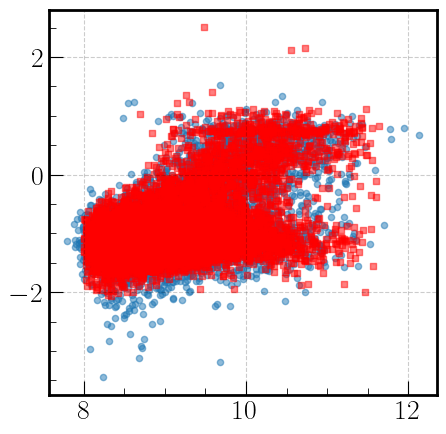

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

samples = gen_samples[::100]
pos = samples[..., :3]
vel = samples[..., 3:6]
mass = samples[..., 6]
vmax_tilde = samples[..., 7] / 100
rad = np.linalg.norm(pos, axis=-1)

ax.scatter(mass, np.log10(vmax_tilde), s=20, color='C0', alpha=0.5)

samples = truth_samples[::100]
pos = samples[..., :3]
vel = samples[..., 3:6]
mass = samples[..., 6]
vmax_tilde = samples[..., 7] / 100
rad = np.linalg.norm(pos, axis=-1)

ax.scatter(
    mass, np.log10(vmax_tilde), s=20, marker='s', color='r', alpha=0.5)


plt.show()

### Pair-wise distances

In [91]:
def calc_pair_dist(pos1, pos2):
    diff = (pos1[:, None, :] - pos2[None, :, :])
    dist = np.sqrt((diff**2).sum(axis=-1))
    dist = dist[dist > 0]  # only works if there are no particles at the same position
    return dist

def calc_tpcf(pos, num_random_factor=10, box_size=1):
    # randomly generate the catalogs7
    num_random = int(num_random_factor * len(pos))
    pos_random = np.random.uniform(
        low=-box_size, high=box_size, size=(num_random, pos.shape[-1]))
    DR_dist = calc_pair_dist(pos, pos_random)
    RR_dist = calc_pair_dist(pos_random, pos_random)
    DD_dist = calc_pair_dist(pos, pos)

    # calculate the tpcf
    return DD_dist, RR_dist, DR_dist

In [92]:
truth_pair_dist = []
for i in range(num_cond_bins):
    temp = []
    for sample in truth_samples_bins[i]:
        truth_pos = sample[:, :3]
        temp.append(calc_pair_dist(truth_pos, truth_pos))
    truth_pair_dist.append(np.stack(temp))

gen_pair_dist = []
for i in range(num_cond_bins):
    temp = []
    for sample in gen_samples_bins[i]:
        gen_pos = sample[:, :3]
        temp.append(calc_pair_dist(gen_pos, gen_pos))
    gen_pair_dist.append(np.stack(temp))

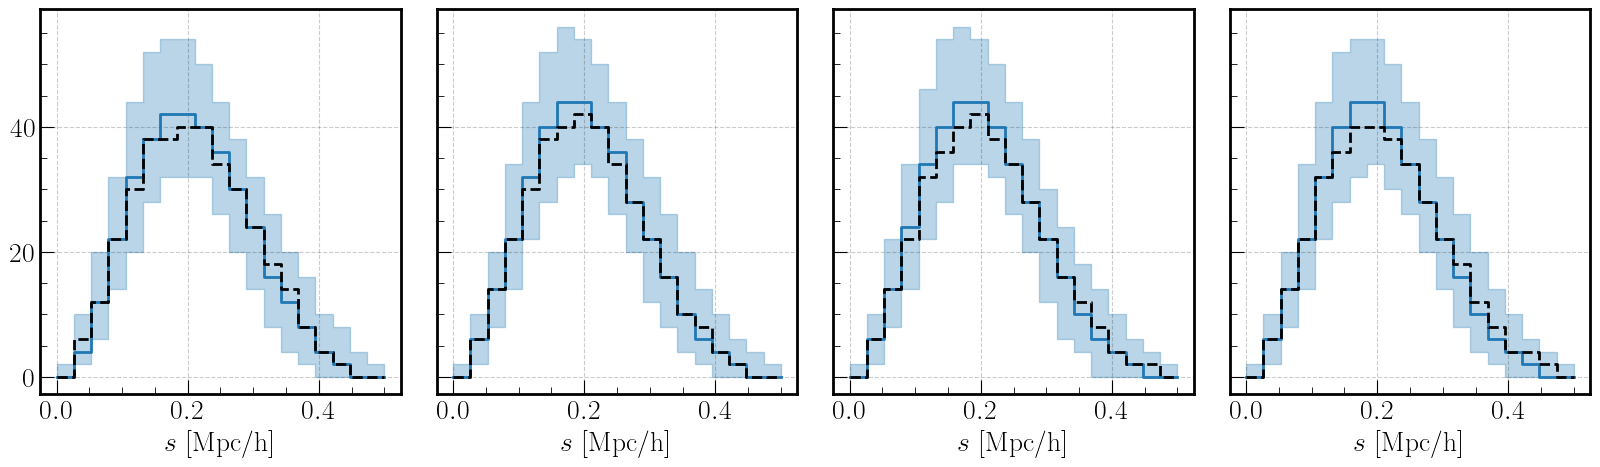

In [93]:
# pair-wise distance bins
bins = np.linspace(0, 0.5, 20)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_cond_bins, figsize=(5 * num_cond_bins, 5), sharex=True, sharey=True)

for i in range(num_cond_bins):
    ax = axes[i]

    counts_q = get_histogram_q(
        gen_pair_dist[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    counts_q = get_histogram_q(
        truth_pair_dist[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')

# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$s$ [Mpc/h]')

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Pair-wise velocities

In [94]:
truth_pair_vel = []
for i in range(num_cond_bins):
    temp = []
    for sample in truth_samples_bins[i]:
        truth_vel = sample[:, 3:6]
        temp.append(calc_pair_dist(truth_vel, truth_vel))
    truth_pair_vel.append(np.stack(temp))

gen_pair_vel = []
for i in range(num_cond_bins):
    temp = []
    for sample in gen_samples_bins[i]:
        gen_vel = sample[:, 3:6]
        temp.append(calc_pair_dist(gen_vel, gen_vel))
    gen_pair_vel.append(np.stack(temp))

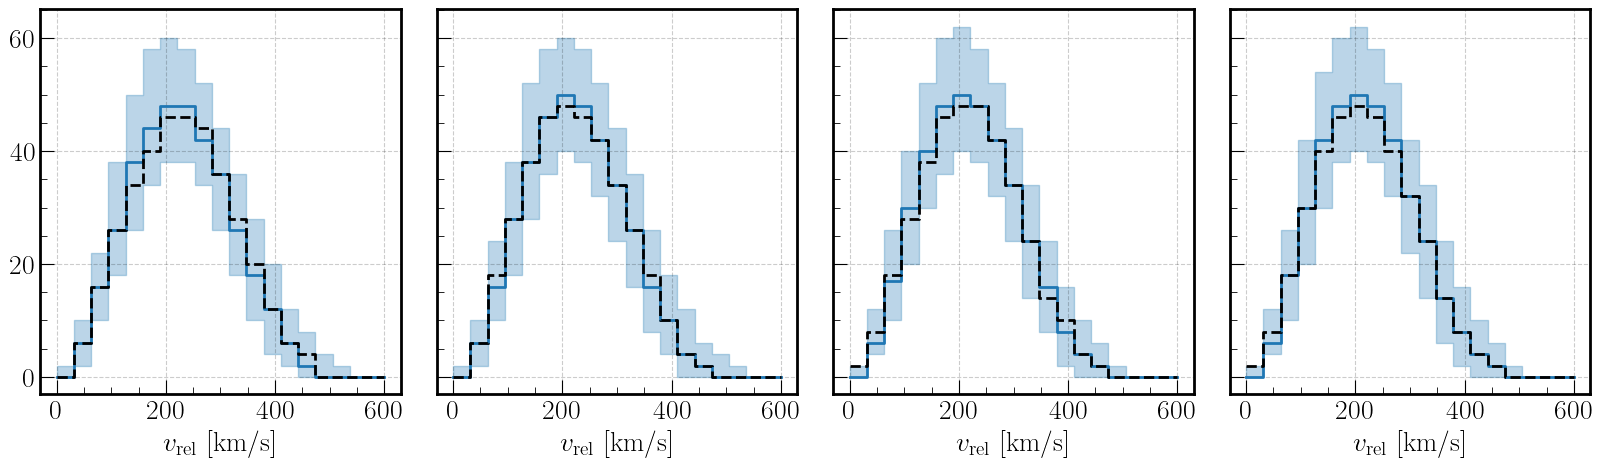

In [95]:
# pair-wise distance bins
bins = np.linspace(0, 600, 20)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_cond_bins, figsize=(5 * num_cond_bins, 5), sharex=True, sharey=True)

for i in range(num_cond_bins):
    ax = axes[i]

    counts_q = get_histogram_q(
        gen_pair_vel[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    counts_q = get_histogram_q(
        truth_pair_vel[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')

# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$v_\mathrm{rel}$ [km/s]')

# create handles
handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()